In [1]:
# import basic libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Auxiliary functions
# function to load images
def input_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for d in os.listdir(folder):
        if not d.startswith('.'):
            if d in ['A']:
                label = 0
            elif d in ['B']:
                label = 1
            elif d in ['C']:
                label = 2
            elif d in ['D']:
                label = 3
            elif d in ['E']:
                label = 4
            elif d in ['F']:
                label = 5
            elif d in ['G']:
                label = 6
            elif d in ['H']:
                label = 7
            elif d in ['I']:
                label = 8
            elif d in ['J']:
                label = 9
            elif d in ['K']:
                label = 10
            elif d in ['L']:
                label = 11
            elif d in ['M']:
                label = 12
            elif d in ['N']:
                label = 13
            elif d in ['O']:
                label = 14
            elif d in ['P']:
                label = 15
            elif d in ['Q']:
                label = 16
            elif d in ['R']:
                label = 17
            elif d in ['S']:
                label = 18
            elif d in ['T']:
                label = 19
            elif d in ['U']:
                label = 20
            elif d in ['V']:
                label = 21
            elif d in ['W']:
                label = 22
            elif d in ['X']:
                label = 23
            elif d in ['Y']:
                label = 24
            elif d in ['Z']:
                label = 25
            elif d in ['del']:
                label = 26
            elif d in ['nothing']:
                label = 27
            elif d in ['space']:
                label = 28           
            else:
                label = 29
            for file in tqdm(os.listdir(folder + d)):
                img_file = cv2.imread(folder + d + '/' + file)
                if img_file is None:
                    continue
#                 print(img_file)
#                 print("================================")
                img_file = skimage.transform.resize(img_file, (img_size, img_size))
                img = np.asarray(img_file)
                X.append(img)
                y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [3]:
# read data
train_data_raw = pd.read_csv('./data/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('./data/sign_mnist_test.csv', sep=",")
all_data_raw = pd.concat([train_data_raw,test_data_raw], axis=0)

print(len(train_data_raw))
print(len(test_data_raw))

27455
7172


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [68]:
#channels = 1
channels = 3
#in_size  = 28*28       # images are 28x28 pixels
in_size = 64*64*channels
out_size = 29           # number of classes
#n_feat = 28*28         # number of features
n_feat = 64*64
epochs = 10       
batch_size = 64
learning_rate = 0.01
momentum = 0.000
n_hidden = 128           # number of hidden units


In [24]:
# Create custom dataloader object for dataset 1
class asl_dataset(torch.utils.data.Dataset):

  def __init__(self, src_file, num_rows=None):
    y_tmp = src_file['label']
    y_tmp = y_tmp.values
    x_tmp = src_file.drop('label', axis=1)
    x_tmp = x_tmp.values
    self.x_data = torch.tensor(x_tmp, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y_tmp, dtype=torch.long).to(device)

  def __len__(self):
    return len(self.x_data)  # required

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = self.x_data[idx, 0:784]
    label = self.y_data[idx]
    #sample = \
    #  { 'pixels' : preds, 'class' : pol }
    return image, label

# Create custom dataloader object for dataset 2
class asl64_dataset(torch.utils.data.Dataset):

  def __init__(self, data, label, num_rows=None):
    y_tmp = label
    #y_tmp = y_tmp.values
    x_tmp = data
    #x_tmp = x_tmp.values
    self.x_data = torch.tensor(x_tmp, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y_tmp, dtype=torch.long).to(device)

  def __len__(self):
    return len(self.x_data)  # required

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = self.x_data[idx, 0:12288]
    label = self.y_data[idx]
    return image, label

In [25]:
# Digits dataset
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_data_ldr = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_data_ldr = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

In [26]:
# load dataset 1 (MNIST csv)
# load torch data loaders

train_data_ds = asl_dataset(train_data_raw)
test_data_ds = asl_dataset(test_data_raw)

train_data_ldr = torch.utils.data.DataLoader(train_data_ds, batch_size=batch_size, shuffle=True)
test_data_ldr = torch.utils.data.DataLoader(test_data_ds, batch_size=1000, shuffle=True)

In [27]:
# load dataset 2 (asl alphabet kaggle)
from tqdm import tqdm
import cv2
import skimage

img_size = 64
train_dir = "../data/asl_alphabet/asl_alphabet_train/asl_alphabet_train/"
test_dir = "../data/asl_alphabet/asl_alphabet_test/asl_alphabet_test/"

# To use only if reload needed
#xtrain, ytrain = input_data(train_dir)
#xtest, ytest = get_data(test_dir)

# Preloaded numpy arrays
#xtrain = np.load('xtrain.npy')
#ytrain = np.load('ytrain.npy')
#xtest = np.load('xtest.npy')
#ytest = np.load('ytest.npy')

from sklearn.model_selection import train_test_split
xtrain_s, xtest_s, ytrain_s, ytest_s = train_test_split(xtrain, ytrain, test_size=0.2)

train_data64_ds = asl64_dataset(xtrain_s, ytrain_s)
test_data64_ds = asl64_dataset(xtest_s, ytest_s)

train_data_ldr = torch.utils.data.DataLoader(train_data64_ds, batch_size=batch_size, shuffle=True)
test_data_ldr = torch.utils.data.DataLoader(test_data64_ds, batch_size=1000, shuffle=True)


In [30]:
# Show sample dataset 1, method 1
#x_data, y_data = train_data_ldr.dataset.__getitem__(1)
#pixels = x_data.reshape(64,64,3)
#plt.subplot()
#sns.heatmap(data=pixels)

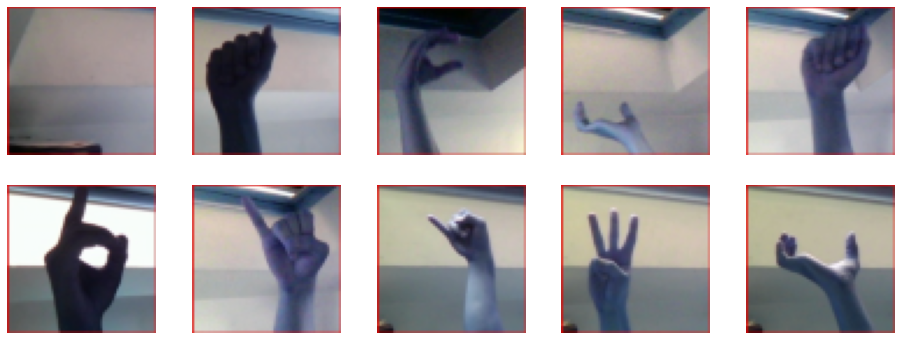

In [31]:
# # Show sample dataset 1, method 2
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_data_ldr.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy().reshape(64,64,3))
    plt.axis('off');

In [32]:
# Create label dictionary
alph = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
        10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
        18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y' }

In [69]:
# Create network arquitectures
# simplest NN architecture
class simpleNNv1(nn.Module):
    def __init__(self, in_size, n_hidden, out_size):
        super(simpleNNv1, self).__init__()
        self.in_size = in_size
        self.network = nn.Sequential(
            nn.Linear(in_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, out_size)
        )

    def forward(self, x):
        x = x.view(-1, self.in_size)
        return self.network(x)

# Gunnika architecture
class Network(nn.Module):
    def __init__(self, in_size, n_hidden, out_size):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3,10,3)
        self.conv2 = nn.Conv2d(30,20,3)
        self.conv3 = nn.Conv2d(20,30,3)
        
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(0.2)
        
        self.fc1 = nn.Linear(30*3*3, 270)
        self.fc2 = nn.Linear(270,26)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = x.view(-1, 30 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.softmax(F.relu(self.fc2(x)))
        
        return(x)

In [70]:
accuracy_list = []

def train(epoch, model, data_loader, optim, lr):
    model.train()
    optimizer = optim(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    for batch_idx, (data, target) in enumerate(data_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.view(-1, 64, 64, channels)

        optimizer.zero_grad()
        output = model(data)

        loss = F.cross_entropy(output, target) #cross entropy
        loss.backward() # cross entropy loss
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_data_ldr.dataset),
                100. * batch_idx / len(train_data_ldr), loss.item()))
    scheduler.step()
            
def test(model, data_loader): # same as train but using eval()
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_data_ldr:
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.view(-1, 64*64*channels)

        output = model(data)
        
        test_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_data_ldr.dataset)
    accuracy = 100. * correct / len(test_data_ldr.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_data_ldr.dataset),accuracy))

In [71]:
import torch.optim.lr_scheduler
# instantiate and run nn
# Network architecture 1
model_fnn = simpleNNv1(in_size, n_hidden, out_size) # instantiation
model_fnn.to(device)
optimizer = torch.optim.SGD


# Network architecture 2
#model_fnn = Network(in_size, n_hidden, out_size)
#optimizer = optim.SGD(model_fnn.parameters(), learning_rate, momentum=0.007)
#criterion = nn.CrossEntropyLoss()
#summary(model_fnn, input_size = (1,784), batch_size = -1)

In [72]:
for epoch in range(0, epochs):
    train(epoch, model_fnn, train_data_ldr, optimizer, learning_rate)
    test(model_fnn, test_data_ldr)

Train Epoch: 0 [0/69600 (0%)]	Loss: 3.396981
Train Epoch: 0 [10000/69600 (14%)]	Loss: 3.279353
Train Epoch: 0 [20000/69600 (29%)]	Loss: 3.221251
Train Epoch: 0 [30000/69600 (43%)]	Loss: 3.046172
Train Epoch: 0 [40000/69600 (57%)]	Loss: 3.022271
Train Epoch: 0 [50000/69600 (72%)]	Loss: 2.930399
Train Epoch: 0 [60000/69600 (86%)]	Loss: 2.958096

Test set: Average loss: 2.8487, Accuracy: 3233/17400 (19%)

Train Epoch: 1 [0/69600 (0%)]	Loss: 2.925200
Train Epoch: 1 [10000/69600 (14%)]	Loss: 2.703239
Train Epoch: 1 [20000/69600 (29%)]	Loss: 2.777218
Train Epoch: 1 [30000/69600 (43%)]	Loss: 2.645495
Train Epoch: 1 [40000/69600 (57%)]	Loss: 2.655959
Train Epoch: 1 [50000/69600 (72%)]	Loss: 2.786742
Train Epoch: 1 [60000/69600 (86%)]	Loss: 2.357505

Test set: Average loss: 2.4920, Accuracy: 4504/17400 (26%)

Train Epoch: 2 [0/69600 (0%)]	Loss: 2.573439
Train Epoch: 2 [10000/69600 (14%)]	Loss: 2.574153
Train Epoch: 2 [20000/69600 (29%)]	Loss: 2.515260
Train Epoch: 2 [30000/69600 (43%)]	Loss: 2.